# Bayesian analysis of the Curtis Flowers trials

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate, savefig

On September 5, 2020, prosecutors in Mississippi dropped charges against [Curtis Flowers](https://en.wikipedia.org/wiki/Curtis_Flowers), freeing him after 23 years of incarceration.

Flowers had been tried six times for a 1996 multiple murder.  Two trials ended in a mistrial due to a hung jury; four trials ended in convictions.  

According to [this NPR report](https://www.npr.org/2020/09/05/910061573/after-6-trials-prosecutors-drop-charges-against-curtis-flowers)

> After each conviction, a higher court struck down the initial ruling. The latest ruling invalidating Flowers' conviction, and death sentence, came from the U.S. Supreme Court in June of last year. The justices noted the Mississippi Supreme Court had found that in three prior convictions the prosecution had misrepresented evidence and deliberately eliminated Black jurors.

Since the racial composition of the juries was the noted reason the last conviction was invalidated, the purpose of this article is to explore the relationship between the composition of the juries and the outcome of the trials.

Flowers' trials were the subject of the [In the Dark](https://www.apmreports.org/episode/2018/05/01/in-the-dark-s2e1) podcast, which reported the racial composition of the juries and the outcomes:

```
Trial         Jury                     Outcome
  1           All white                Guilty
  2           11 white, 1 black        Guilty
  3           11 white, 1 black        Guilty
  4           7 white, 5 black         Hung jury
  5           9 white, 3 black         Hung jury
  6           11 white, 1 black        Guilty
```

We can use this data to estimate the probability that white and black jurors would vote to convict, and then use those estimates to compute the probability of a guilty verdict.

As a modeling simplification, I'll assume:

* The six juries were presented with essentially the same evidence, prosecution case, and defense;

* The probabilities of conviction did not change over the years of the trials (from 1997 to 2010); and

* Each juror votes independently of the others; that is, I ignore interactions between jurors.

I'll use the same prior distribution for white and black jurors, a uniform distribution from 0 to 1.

In [4]:
ps = np.linspace(0, 1, 101)
prior_p1 = Pmf(1.0, ps)
prior_p1.index.name = 'p1'

In [5]:
prior_p2 = Pmf(1.0, ps)
prior_p2.index.name = 'p2'

To prepare for the updates, I'll form a joint distribution of the two probabilities.

In [6]:
from utils import make_joint

joint = make_joint(prior_p2, prior_p1)

In [7]:
prior_pmf = Pmf(joint.stack())
prior_pmf.head()

p1   p2  
0.0  0.00    1.0
     0.01    1.0
     0.02    1.0
     0.03    1.0
     0.04    1.0
dtype: float64

Here's how we compute the update.

Assuming that a guilty verdict must be unanimous, the probability of conviction is

$ p = p_1^{n_1} ~ p_2^{n_2}$

where

* $p_1$ is the probability a white juror votes to convict
* $p_2$ is the probability a black juror votes to convict
* $n_1$ is the number of white jurors
* $n_2$ is the number of black jurors

The probability of an acquittal or hung jury is the complement of $p$.

The following function performs a Bayesian update given the composition of the jury and the outcome, either `'guilty'` or `'hung'`.  We could also do an update for an acquittal, but since that didn't happen, I didn't implement it.

In [8]:
def update(prior, data):
    n1, n2, outcome = data
    likelihood = prior.copy()

    for p1, p2 in prior.index:
        like = p1**n1 * p2**n2
        if outcome == 'guilty':
            likelihood.loc[p1, p2] = like
        elif outcome == 'hung':
            likelihood.loc[p1, p2] = 1-like
        else:
            raise ValueError()
            
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

I'll use the following function to plot the marginal posterior distributions after each update.

In [9]:
from utils import pmf_marginal

def plot_marginals(posterior):
    marginal0 = pmf_marginal(posterior, 0)
    marginal0.plot(label='white')
    
    marginal1 = pmf_marginal(posterior, 1)
    marginal1.plot(label='black')

    decorate(xlabel='Probability of voting to convict',
             ylabel='PDF',
             title='Marginal posterior distributions')

Here's the update for the first trial.

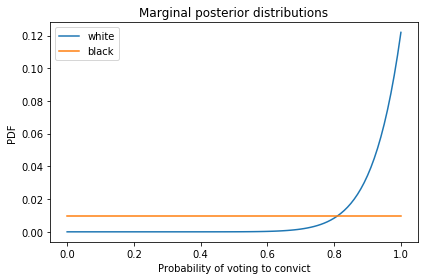

In [10]:
data1 = 12, 0, 'guilty'
posterior1 = update(prior_pmf, data1)
plot_marginals(posterior1)

Since there were no black jurors for the first trial, we learn nothing about their probability of conviction, so the posterior distribution is the same as the prior.

The posterior distribution for white voters reflects the data that 12 of them voted to convict.

Here are the posterior distributions after the second trial.

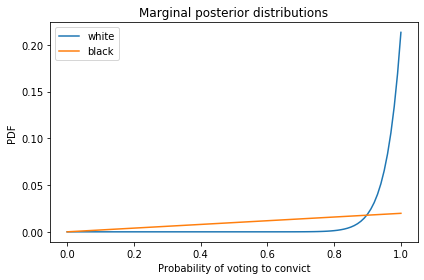

In [11]:
data2 = 11, 1, 'guilty'
posterior2 = update(posterior1, data2)
plot_marginals(posterior2)

And the third.

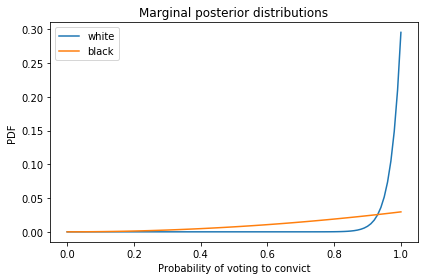

In [12]:
data3 = 11, 1, 'guilty'
posterior3 = update(posterior2, data3)
plot_marginals(posterior3)

Since the first three verdicts were guilty, we infer that all 36 jurors voted to convict, so the estimated probabilities for both groups are high.

The fourth trials ended in a mistrial due to a hung jury, which implies that at least one juror refused to vote to convict.  That decreases the estimated probabilities for both juror pools, but it has a bigger effect on the estimate for black jurors because the total prior data pertaining to black jurors is less, so the same amount of new data moves the needle more.

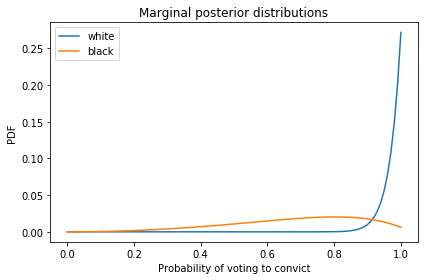

In [13]:
data4 = 7, 5, 'hung'
posterior4 = update(posterior3, data4)
plot_marginals(posterior4)

The effect of the fifth trial is similar; it decreases the estimates for both pools, but the effect on the estimate for black jurors is greater.

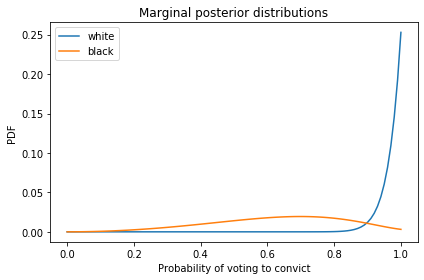

In [14]:
data5 = 9, 3, 'hung'
posterior5 = update(posterior4, data5)
plot_marginals(posterior5)

Finally, here are the posterior distributions after all six trials.

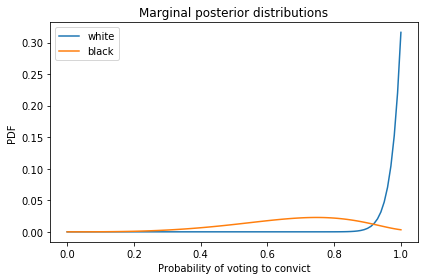

In [15]:
data6 = 11, 1, 'guilty'
posterior6 = update(posterior5, data6)
plot_marginals(posterior6)

The posterior distributions for the two pools are substantially different.  Here are the posterior means.

In [16]:
marginal_p1 = pmf_marginal(posterior6, 0)
marginal_p2 = pmf_marginal(posterior6, 1)

marginal_p1.mean(), marginal_p2.mean(), 

(0.9795476889311339, 0.6802593488434)

Based on the outcomes of all six trials, we estimate that the probability is 98% that a white juror would vote to convict, and the probability is 68% that a black juror would vote to convict.

Again, those results are based on the modeling simplifications that

* All six juries saw essentially the same evidence,

* The probabilities we're estimating did not change over the period of the trials, and

* Interactions between jurors did not have substantial effects on their votes.

## Prediction

Now we can use the joint posterior distribution to estimate the probability of conviction as a function of the composition of the jury.

I'll draw a sample from the joint posterior distribution.

In [17]:
sample = posterior6.sample(1000)

Here's the probability that white jurors were more likely to convict.

In [18]:
np.mean([p1 > p2 for p1, p2 in sample])

0.889

The following function takes this sample and a hypothetical composition and returns the posterior predictive distribution for the probability of conviction.

In [19]:
def prob_guilty(sample, n1, n2):
    ps = [p1**n1 * p2**n2 for p1, p2 in sample]
    return Pmf.from_seq(ps)

According to [Wikipedia](https://en.wikipedia.org/wiki/Montgomery_County,_Mississippi):

> As of the 2010 United States Census, there were 10,925 people living in the county. 53.0% were White, 45.5% Black or African American, 0.4% Asian, 0.1% Native American, 0.5% of some other race and 0.5% of two or more races. 0.9% were Hispanic or Latino (of any race).

A jury drawn at random from the population of Montgomery County would be expected to have 5 or 6 black jurors.

Here's the probability of conviction with a panel of 7 white and 5 black jurors.

In [20]:
pmf = prob_guilty(sample, 7, 5)
pmf.mean(), pmf.credible_interval(0.9)

(0.1536247710661592, array([2.47609900e-04, 5.72165499e-01]))

And with 6 white and 6 black jurors.

In [21]:
pmf = prob_guilty(sample, 6, 6)
pmf.mean(), pmf.credible_interval(0.9)

(0.14068070740861993, array([5.00964985e-05, 5.70871197e-01]))

With a jury that represents the population of Montgomery County, the probability Flowers would be convicted is 14-15%.

However, notice that the credible intervals for these estimates are quite wide.  Based on the data, the actual probabilities could be in the range from near 0 to 50%.

The following figure shows the probability of conviction as a function of the number of black jurors.

The probability of conviction is highest with an all-white jury, and drops quickly if there are a few black jurors.  After that, the addition of more black jurors has a relatively small effect.

These results suggest that all-white juries have a substantially higher probability of convicting a defendant, compared to a jury with even a few non-white jurors.

In [22]:
pmf_seq = []
n2s = range(0, 13)

for n2 in n2s:
    n1 = 12 - n2
    pmf = prob_guilty(sample, n1, n2)
    pmf_seq.append(pmf)

In [23]:
means = [pmf.mean() for pmf in pmf_seq]
lows = [pmf.quantile(0.05) for pmf in pmf_seq]
highs = [pmf.quantile(0.95) for pmf in pmf_seq]

means

[0.5538327053225913,
 0.3418368780199899,
 0.25039614520645626,
 0.20187886989068096,
 0.1726469824064479,
 0.1536247710661592,
 0.14068070740861993,
 0.13168895287399013,
 0.12545481771765174,
 0.12126313084374142,
 0.1186668473680227,
 0.11737944315539342,
 0.11721642419343986]

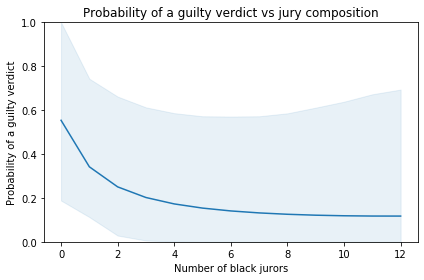

In [24]:
plt.plot(n2s, means)
plt.fill_between(n2s, lows, highs, color='C0', alpha=0.1)

decorate(xlabel='Number of black jurors',
         ylabel='Probability of a guilty verdict',
         title='Probability of a guilty verdict vs jury composition',
         ylim=[0, 1])

## Double Check

Let's compute the results a different way to double check.

For the four guilty verdicts, we don't need to make or update the joint distribution; we can update the distributions for the two pools separately.

In [25]:
from scipy.stats import binom

k1 = 12 + 11 + 11 + 11
like1 = binom(k1, ps).pmf(k1)
prior_p1 = Pmf(like1, ps)

In [26]:
k2 = 0 + 1 + 1 + 1
like2 = binom(k2, ps).pmf(k2)
prior_p2 = Pmf(like2, ps)

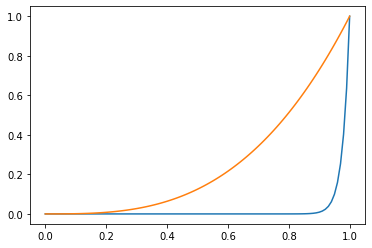

In [27]:
prior_p1.plot()
prior_p2.plot()

We can use the posteriors from those updates as priors and update them based on the two trials that resulted in a hung jury.

In [28]:
prior = Pmf(make_joint(prior_p2, prior_p1).stack())
posterior = update(prior, data4)
posterior = update(posterior, data5)

The posterior marginals look the same.

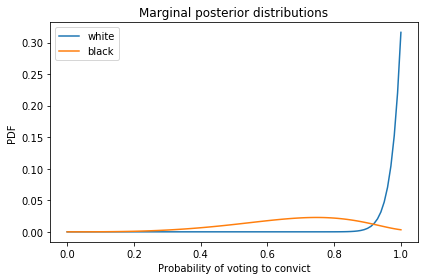

In [29]:
plot_marginals(posterior)

And yield the same posterior means.

In [30]:
marginal_p1 = pmf_marginal(posterior, 0)
marginal_p2 = pmf_marginal(posterior, 1)

marginal_p1.mean(), marginal_p2.mean(), 

(0.9795476889311339, 0.6802593488434)

Here's the probability that a fair jury would convict four times out of six.

In [32]:
binom.pmf(4, 6, 0.15)

0.0054864843750000005